## 6.01 - Supervised Learning Model Comparison

Recall the "data science process."

1. Define the problem.
2. Gather the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

In this lab, we're going to focus mostly on creating (and then comparing) many regression and classification models. Thus, we'll define the problem and gather the data for you.
Most of the questions requiring a written response can be written in 2-3 sentences.

### Step 1: Define the problem.

You are a data scientist with a financial services company. Specifically, you want to leverage data in order to identify potential customers.

If you are unfamiliar with "401(k)s" or "IRAs," these are two types of retirement accounts. Very broadly speaking:
- You can put money for retirement into both of these accounts.
- The money in these accounts gets invested and hopefully has a lot more money in it when you retire.
- These are a little different from regular bank accounts in that there are certain tax benefits to these accounts. Also, employers frequently match money that you put into a 401k.
- If you want to learn more about them, check out [this site](https://www.nerdwallet.com/article/ira-vs-401k-retirement-accounts).

We will tackle one regression problem and one classification problem today.
- Regression: What features best predict one's income?
- Classification: Predict whether or not one is eligible for a 401k.

Check out the data dictionary [here](http://fmwww.bc.edu/ec-p/data/wooldridge2k/401KSUBS.DES).

### NOTE: When predicting `inc`, you should pretend as though you do not have access to the `e401k`, the `p401k` variable, and the `pira` variable. When predicting `e401k`, you may use the entire dataframe if you wish.

### Step 2: Gather the data.

##### 1. Read in the data from the repository.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost as xgb

In [2]:
data = pd.read_csv('./401ksubs.csv')
df = pd.DataFrame(data)
df.head()

,e401k,inc,marr,male,age,fsize,nettfa,p401k,pira,incsq,agesq
0,0,13.170,0,0,40,1,4.575,0,1,173.4489,1600
1,1,61.230,0,1,35,1,154.000,1,0,3749.1130,1225
2,0,12.858,1,0,44,2,0.000,0,0,165.3282,1936
3,0,98.880,1,1,44,2,21.800,0,0,9777.2540,1936
4,0,22.614,0,0,53,1,18.450,0,0,511.3930,2809


##### 2. What are 2-3 other variables that, if available, would be helpful to have?

### A:
Property value, no. of properties owned, home address, car ownership.

##### 3. Suppose a peer recommended putting `race` into your model in order to better predict who to target when advertising IRAs and 401(k)s. Why would this be an unethical decision?

### A:
Racial discrimination/profiling. Are we implying certain races earn more, and some earn less?

## Step 3: Explore the data.

##### 4. When attempting to predict income, which feature(s) would we reasonably not use? Why?

### A:
1. obviously incsq: It is derived from inc ('income').

2. e401k, e401k: Many people whether rich or poor can be eligible for and can participate in a 401k plan. These are not strong enough discriminating features.

"As long as your employer offers a 401(k) plan... then most employees are eligible to participate... require employers to let employees participate if they're at least 21 years old and have completed at least one year of service with that employer... many part-time employees end up being eligible even under the strictest plan guidelines,"

https://www.fool.com/retirement/how-to-open-a-401k-account-retirement.aspx

3. pira: likewise for IRA accounts 

"If you (or your spouse) earn taxable income and are under age 70 ½, you can contribute. It's as easy as that."

https://money.cnn.com/retirement/guide/IRA_traditional.moneymag/index3.htm?iid=EL

In [3]:
X = df.drop(columns=['e401k','p401k','pira','inc','incsq'])
y = df['inc']

In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9275 entries, 0 to 9274
Data columns (total 6 columns):
marr      9275 non-null int64
male      9275 non-null int64
age       9275 non-null int64
fsize     9275 non-null int64
nettfa    9275 non-null float64
agesq     9275 non-null int64
dtypes: float64(1), int64(5)
memory usage: 434.8 KB


In [5]:
pd.DataFrame(y).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9275 entries, 0 to 9274
Data columns (total 1 columns):
inc    9275 non-null float64
dtypes: float64(1)
memory usage: 72.5 KB


No nulls.

In [6]:
X.describe()

,marr,male,age,fsize,nettfa,agesq
count,9275.000000,9275.000000,9275.000000,9275.000000,9275.000000,9275.000000
mean,0.628571,0.204420,41.080216,2.885067,19.071675,1793.652722
std,0.483213,0.403299,10.299517,1.525835,63.963838,895.648841
min,0.000000,0.000000,25.000000,1.000000,-502.302000,625.000000
25%,0.000000,0.000000,33.000000,2.000000,-0.500000,1089.000000
50%,1.000000,0.000000,40.000000,3.000000,2.000000,1600.000000
75%,1.000000,0.000000,48.000000,4.000000,18.449500,2304.000000
max,1.000000,1.000000,64.000000,13.000000,1536.798000,4096.000000


Figures look sensible. 'nettfa' has some negative figures but that's sensible as some people may have huge debts.

##### 5. What two variables have already been created for us through feature engineering? Come up with a hypothesis as to why subject-matter experts may have done this.
> This need not be a "statistical hypothesis." Just brainstorm why SMEs might have done this!

### A:
income^2 and age^2. 'age' must have been a strong predictor of income (higher salary with seniority), and whether one is going to be a rich client for 401k plans. Likewise, 'income' itself is directly a strong predictor as to whether one is a rich client for 401k plans.

##### 6. Looking at the data dictionary, one variable description appears to be an error. What is this error, and what do you think the correct value would be?

### A:
'inc' and 'age' both are wrongly labelled as 'inc^2' and 'age^2' respectively. Also, 'inc' should be in the thousands (just like nett total financial assets), hence should be labelled 'inc ($1000)'.

## Step 4: Model the data. (Part 1: Regression Problem)

Recall:
- Problem: What features best predict one's income?
- When predicting `inc`, you should pretend as though you do not have access to the `e401k`, the `p401k` variable, and the `pira` variable.

##### 7. List all modeling tactics we've learned that could be used to solve a regression problem (as of Wednesday afternoon of Week 6). For each tactic, identify whether it is or is not appropriate for solving this specific regression problem and explain why or why not.

Regression models 
1. single or multiple linreg/lasso/ridge. Suitable to predict income, as they work well with continuous target variables like income.
2. or decision trees. Also suitable, as Decision trees work well with either categorical (DecisionTreeClassifier, BaggingClassifier) or numerical (DecisionTreeRegressor, BaggingRegressor) target variables. However, for income (a continuous target variable) we need to segment it into bins via DecisionTreeRegressor, but in doing so, we may lose information.
https://medium.com/greyatom/decision-trees-a-simple-way-to-visualize-a-decision-dc506a403aeb
3. or KNeighborsRegressor. Also suitable for continuous variables, like income.

##### 8. Regardless of your answer to number 7, fit at least one of each of the following models to attempt to solve the regression problem above:
    - a multiple linear regression model
    - a k-nearest neighbors model
    - a decision tree
    - a set of bagged decision trees
    - a random forest
    - an Adaboost model
    - a support vector regressor
    
> As always, be sure to do a train/test split! In order to compare modeling techniques, you should use the same train-test split on each. I recommend setting a random seed here.

> You may find it helpful to set up a pipeline to try each modeling technique, but you are not required to do so!

In [7]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# baseline linreg model
linreg = LinearRegression()
linreg.fit(X_train, y_train)
print('Train Score:',linreg.score(X_train, y_train))
print('Test Score :',linreg.score(X_test, y_test))
y_train_pred_linreg = linreg.predict(X_train)
y_test_pred_linreg = linreg.predict(X_test)
pd.DataFrame(linreg.coef_,X_train.columns, columns=['coef']).sort_values(by='coef',ascending=False)

Train Score: 0.2925748369332385
Test Score : 0.27494825151995306


,coef
marr,21.298405
age,3.083980
male,3.022602
nettfa,0.124052
agesq,-0.035157
fsize,-2.150561


 How about RidgeCV?

In [9]:
# linreg (ridgecv) model
ridgecv_alphas = np.linspace(0.1,0.1,10)
ridgecv = RidgeCV(alphas=ridgecv_alphas, cv=5)
ridgecv.fit(X_train, y_train)
print('Optimal alpha:',ridgecv.alpha_)
print('Train Score:',ridgecv.score(X_train, y_train))
print('Test Score :',ridgecv.score(X_test, y_test))
y_train_pred_ridgecv = ridgecv.predict(X_train)
y_test_pred_ridgecv = ridgecv.predict(X_test)
pd.DataFrame(ridgecv.coef_,X_train.columns, columns=['coef']).sort_values(by='coef',ascending=False)

Optimal alpha: 0.1
Train Score: 0.2925748358292586
Test Score : 0.2749480419503103


,coef
marr,21.296346
age,3.083894
male,3.021861
nettfa,0.124053
agesq,-0.035156
fsize,-2.150224


No better than baseline score. How about LassoCV?

In [10]:
# linreg (lassocv) model
lassocv_alphas = np.logspace(0.1,0.1,100)
lassocv = LassoCV(alphas=lassocv_alphas, cv=5, random_state=42)
lassocv.fit(X_train, y_train)
print('Optimal alpha:',lassocv.alpha_)
print('Train Score:',lassocv.score(X_train, y_train))
print('Test Score :',lassocv.score(X_test, y_test))
y_train_pred_lassocv = lassocv.predict(X_train)
y_test_pred_lassocv = lassocv.predict(X_test)
pd.DataFrame(lassocv.coef_,X_train.columns, columns=['coef']).sort_values(by='coef',ascending=False)

Optimal alpha: 1.2589254117941673
Train Score: 0.2635671104439756
Test Score : 0.24447888033462417


,coef
marr,11.225632
age,1.844117
nettfa,0.130447
male,0.000000
fsize,-0.000000
agesq,-0.020785


No better than baseline score.  How about knn?

In [11]:
# knn
knn = KNeighborsRegressor()
params = {'n_neighbors':[10,15,30],
          'weights':['uniform','distance'],
          'algorithm':['ball_tree','kd_tree'],
          'leaf_size':[30,50,80]}
gs = GridSearchCV(knn,param_grid=params,cv=5,n_jobs=-1)
gs.fit(X_train, y_train)
print('Best params:',gs.best_params_)
print('Train Score:',gs.score(X_train, y_train))
print('Test Score :',gs.score(X_test, y_test))
knn_best = gs.best_estimator_
y_train_pred_knn_best = knn_best.predict(X_train)
y_test_pred_knn_best = knn_best.predict(X_test)

Best params: {'algorithm': 'kd_tree', 'leaf_size': 50, 'n_neighbors': 15, 'weights': 'uniform'}
Train Score: 0.3854519210087112
Test Score : 0.2790084891137822


No better than baseline score. How about a single decision tree regressor?

In [12]:
# decision tree regressor, in pipeline, with gridsearchcv
dtr = DecisionTreeRegressor(random_state=42)
params = {'max_depth':[2,5,8], 
          'max_features':['auto','sqrt'], 
          'min_samples_leaf':[1,5,8],
          'min_samples_split':[2,5]}
gs = GridSearchCV(dtr,param_grid=params,cv=5,n_jobs=-1)
gs.fit(X_train, y_train)
print('Best params:',gs.best_params_)
print('Train Score:',gs.score(X_train, y_train))
print('Test Score :',gs.score(X_test, y_test))
dtr_best = gs.best_estimator_
y_train_pred_dtr_best = dtr_best.predict(X_train)
y_test_pred_dtr_best = dtr_best.predict(X_test)
pd.DataFrame(dtr_best.feature_importances_,
             X_train.columns, columns=['coef']).sort_values(by='coef',ascending=False)

Best params: {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 2}
Train Score: 0.4189609181148386
Test Score : 0.3816854087327116


,coef
nettfa,0.701569
marr,0.248335
age,0.022705
agesq,0.021570
fsize,0.003938
male,0.001883


Better than baseline score. How about a bagged decision tree regressor (multiple bootstrapped datasets, multiple trees)?

In [13]:
# bagged decision tree regressor, using previously saved best estimator
bag_dtr = BaggingRegressor(base_estimator=dtr_best) #unfixed random_state, for different trees
params = {'max_features':[0.3,0.6,1.0],
          'n_estimators':[50,100,200]}
gs = GridSearchCV(bag_dtr,param_grid=params,cv=5,n_jobs=-1)
gs.fit(X_train, y_train)
print('Best params:',gs.best_params_)
print('Train Score:',gs.score(X_train, y_train))
print('Test Score :',gs.score(X_test, y_test))
bdt_best = gs.best_estimator_
y_train_pred_bdt_best = bdt_best.predict(X_train)
y_test_pred_bdt_best = bdt_best.predict(X_test)

Best params: {'max_features': 1.0, 'n_estimators': 200}
Train Score: 0.43069334199524645
Test Score : 0.3936317689978991


Even better than dtr score. How about a random forest (multiple bootstrapped trees but each with random subset of features, and with multiple trees)?

In [14]:
# try random forest
rfr = RandomForestRegressor(random_state=42)
params = {'n_estimators':[200,400],
          'max_depth':[5,8,12], 
          'max_features':['auto','sqrt'], 
          'min_samples_leaf':[8,15,20],
          'min_samples_split':[2,5]}
gs = GridSearchCV(rfr,param_grid=params,cv=5,n_jobs=-1)
gs.fit(X_train, y_train)
print('Best params:',gs.best_params_)
print('Train Score:',gs.score(X_train, y_train))
print('Test Score :',gs.score(X_test, y_test))
rfr_best = gs.best_estimator_
y_train_pred_rfr_best = rfr_best.predict(X_train)
y_test_pred_rfr_best = rfr_best.predict(X_test)
pd.DataFrame(rfr_best.feature_importances_,
             X_train.columns, columns=['coef']).sort_values(by='coef',ascending=False)

Best params: {'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 15, 'min_samples_split': 2, 'n_estimators': 400}
Train Score: 0.47004360216977426
Test Score : 0.4013621114566942


,coef
nettfa,0.684071
marr,0.214252
age,0.039628
agesq,0.038972
fsize,0.013213
male,0.009865


Best score so far. The more trees (or 'n_estimators'), the better. How about Adaboost?

In [16]:
# using the best estimator so far: rfr_best
ada = AdaBoostRegressor(rfr_best)
ada.fit(X_train,y_train)
print('Train Score:',ada.score(X_train, y_train))
print('Test Score :',ada.score(X_test, y_test))
y_train_pred_ada = ada.predict(X_train)
y_test_pred_ada = ada.predict(X_test)
pd.DataFrame(ada.feature_importances_,
             X_train.columns, columns=['coef']).sort_values(by='coef',ascending=False)

Train Score: 0.4161899307058282
Test Score : 0.3022561276592919


,coef
nettfa,0.670864
marr,0.114046
agesq,0.081123
age,0.080587
fsize,0.036797
male,0.016583


Better than linreg and knn and baseline methods, but worse than decision trees/bagged decision trees/random forest methods. How about SVR?

In [17]:
# not using gridsearch here, it takes too long
svr = SVR()
svr.fit(X_train,y_train)
print('Train Score:',svr.score(X_train, y_train))
print('Test Score :',svr.score(X_test, y_test))
y_train_pred_svr = svr.predict(X_train)
y_test_pred_svr = svr.predict(X_test)

C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Score: 0.11967993270565624
Test Score : 0.07218599634463763


##### 9. What is bootstrapping?

### A:
Bootstrapping is any test or metric that relies on random sampling with replacement.

##### 10. What is the difference between a decision tree and a set of bagged decision trees? Be specific and precise!

### A:
Decision tree: '**single set of data**, running through a **single decision tree**'. Accuracy score is solely from this 1 tree's predictions.

Bagged decision tree: '**multiple sets of data** obtained by bootstrapping (sampling with replacement) the original dataset, each running through **different decision trees (ensemble method)**'. Accuracy score is the aggregate mean of all decision trees' predictions. 

##### 11. What is the difference between a set of bagged decision trees and a random forest? Be specific and precise!

### A:
Bagged decision tree: At each node, **ALL** features are considered before splitting at the node.

Random forest: At each node, only a **RANDOM SUBSET** of features (p/3 for regressor trees, sqrt p for classification trees) are considered before splitting at the node.

##### 12. Why might a random forest be superior to a set of bagged decision trees?
> Hint: Consider the bias-variance tradeoff.

### A:
Random forests result in trees each ending up with different features after every split at every node, thereby resulting in decorrelated trees and more reliable average output. Hence random forests are more robust against correlated features. The bias is slightly higher, but the variance is greatly reduced, hence overfitting is greatly reduced too.

## Step 5: Evaluate the model. (Part 1: Regression Problem)

##### 13. Using RMSE, evaluate each of the models you fit on both the training and testing data.

In [18]:
print('linreg (train)              :',mean_squared_error(y_train, y_train_pred_linreg)**0.5)
print('ridgeCV (train)             :',mean_squared_error(y_train, y_train_pred_ridgecv)**0.5)
print('lassoCV (train)             :',mean_squared_error(y_train, y_train_pred_lassocv)**0.5)
print('knn (train)                 :',mean_squared_error(y_train, y_train_pred_knn_best)**0.5)
print('decision tree (train)       :',mean_squared_error(y_train, y_train_pred_dtr_best)**0.5)
print('bagged decision tree (train):',mean_squared_error(y_train, y_train_pred_bdt_best)**0.5)
print('random forest (train)       :',mean_squared_error(y_train, y_train_pred_rfr_best)**0.5)
print('adaboost (train)            :',mean_squared_error(y_train, y_train_pred_ada)**0.5)
print('svr (train)                 :',mean_squared_error(y_train, y_train_pred_svr)**0.5)

print('\nlinreg (test)               :',mean_squared_error(y_test, y_test_pred_linreg)**0.5,
     ', Difference of',mean_squared_error(y_test, y_test_pred_linreg)**0.5-mean_squared_error(y_train, y_train_pred_linreg)**0.5,'from train')
print('ridgeCV (test)              :',mean_squared_error(y_test, y_test_pred_ridgecv)**0.5,
     ', Difference of',mean_squared_error(y_test, y_test_pred_ridgecv)**0.5-mean_squared_error(y_train, y_train_pred_ridgecv)**0.5,'from train')
print('lassoCV (test)              :',mean_squared_error(y_test, y_test_pred_lassocv)**0.5,
     ', Difference of',mean_squared_error(y_test, y_test_pred_lassocv)**0.5-mean_squared_error(y_train, y_train_pred_lassocv)**0.5,'from train')
print('knn (test)                  :',mean_squared_error(y_test, y_test_pred_knn_best)**0.5,
     ', Difference of',mean_squared_error(y_test, y_test_pred_knn_best)**0.5-mean_squared_error(y_train, y_train_pred_knn_best)**0.5,'from train')
print('decision tree (test)        :',mean_squared_error(y_test, y_test_pred_dtr_best)**0.5,
     ', Difference of',mean_squared_error(y_test, y_test_pred_dtr_best)**0.5-mean_squared_error(y_train, y_train_pred_dtr_best)**0.5,'from train')
print('bagged decision tree (test) :',mean_squared_error(y_test, y_test_pred_bdt_best)**0.5,
     ', Difference of',mean_squared_error(y_test, y_test_pred_bdt_best)**0.5-mean_squared_error(y_train, y_train_pred_bdt_best)**0.5,'from train')
print('random forest (test)        :',mean_squared_error(y_test, y_test_pred_rfr_best)**0.5,
     ', Difference of',mean_squared_error(y_test, y_test_pred_rfr_best)**0.5-mean_squared_error(y_train, y_train_pred_rfr_best)**0.5,'from train')
print('adaboost (test)             :',mean_squared_error(y_test, y_test_pred_ada)**0.5,
     ', Difference of',mean_squared_error(y_test, y_test_pred_ada)**0.5-mean_squared_error(y_train, y_train_pred_ada)**0.5,'from train')
print('svr (test)                  :',mean_squared_error(y_test, y_test_pred_svr)**0.5,
     ', Difference of',mean_squared_error(y_test, y_test_pred_svr)**0.5-mean_squared_error(y_train, y_train_pred_svr)**0.5,'from train')



linreg (train)              : 20.164244947447397
ridgeCV (train)             : 20.16424496318116
lassoCV (train)             : 20.57350567488912
knn (train)                 : 18.79401829908604
decision tree (train)       : 18.274452949514924
bagged decision tree (train): 18.089011884460717
random forest (train)       : 17.45266619805475
adaboost (train)            : 18.317976741967485
svr (train)                 : 22.493757748703892

linreg (test)               : 20.89741661081878 , Difference of 0.7331716633713832 from train
ridgeCV (test)              : 20.89741963092309 , Difference of 0.7331746677419275 from train
lassoCV (test)              : 21.331991566007936 , Difference of 0.7584858911188164 from train
knn (test)                  : 20.838822450594034 , Difference of 2.044804151507993 from train
decision tree (test)        : 19.298024189703625 , Difference of 1.0235712401887014 from train
bagged decision tree (test) : 19.110687836769625 , Difference of 1.0216759523089074 from t

##### 14. Based on training RMSE and testing RMSE, is there evidence of overfitting in any of your models? Which ones?

## A:

Perhaps KNN and AdaBoost had the greatest signs of overfitting, as their test RMSE scores were larger than their train RMSE scores by the largest margins (~+2).

##### 15. Based on everything we've covered so far, if you had to pick just one model as your final model to use to answer the problem in front of you, which one model would you pick? Defend your choice.

## A:
I would pick the random forest method, as it yields the lowest RMSE (18.99), and lowest R2 score of 0.40 as seen earlier.

##### 16. Suppose you wanted to improve the performance of your final model. Brainstorm 2-3 things that, if you had more time, you would attempt.

## A:
1. From the optimum gridsearchcv parameters, I would choose a tighter range of values around the best hyperparameters, to gridsearch over. 
2. try out the extra trees regressor (no bootstrapping of original dataset), which might yield better results. This is because splits are done at random at each node, instead of choosing splits based on the greatest drop in Gini impurity. Results may be better with more diversified trees. Also, the 'extra trees' works better when there are a few main predictors, and many irrelevant ones (https://www.thekerneltrip.com/statistics/random-forest-vs-extra-tree/#:~:targetText=The%20main%20difference%20between%20random,(for%20the%20extra%20trees)), which might be the case for this problem - we saw earlier from the linear and decision tree/ensemble methods, that they typically have 2 stronger predictors (high coefficients) and the rest were much weaker (lower coefficients). 
3. try Gradient Boosting, or XG Boost.

In [19]:
# gradient boosting
gbr = GradientBoostingRegressor()
gbr.fit(X_train,y_train)
print('Train Score:',gbr.score(X_train,y_train))
print('Test Score :',gbr.score(X_test,y_test))

Train Score: 0.4604933550646788
Test Score : 0.41431707220450387


C:\Users\Dell\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:36:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train Score: 0.4557327718993076
Test Score : 0.4133378681972416


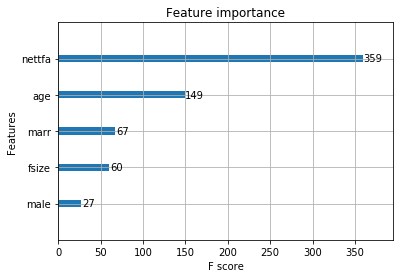

In [20]:
#  xgboost
xgbr = xgb.XGBRegressor()
xgbr.fit(X_train,y_train)
print('Train Score:',xgbr.score(X_train,y_train))
print('Test Score :',xgbr.score(X_test,y_test))

# see importance of different features
xgb.plot_importance(xgbr)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

## Step 4: Model the data. (Part 2: Classification Problem)

Recall:
- Problem: Predict whether or not one is eligible for a 401k.
- When predicting `e401k`, you may use the entire dataframe if you wish.

##### 17. While you're allowed to use every variable in your dataframe, mention at least one disadvantage of using `p401k` in your model.

In [22]:
features = [col for col in df.columns if col!='e401k']
# X = df.drop(columns=['e401k','p401k','pira','inc','incsq'])
# y = df['inc']
features

['inc',
 'marr',
 'male',
 'age',
 'fsize',
 'nettfa',
 'p401k',
 'pira',
 'incsq',
 'agesq']

##### 18. List all modeling tactics we've learned that could be used to solve a classification problem (as of Wednesday afternoon of Week 6). For each tactic, identify whether it is or is not appropriate for solving this specific classification problem and explain why or why not.

##### 19. Regardless of your answer to number 18, fit at least one of each of the following models to attempt to solve the classification problem above:
    - a logistic regression model
    - a k-nearest neighbors model
    - a decision tree
    - a set of bagged decision trees
    - a random forest
    - an Adaboost model
    - a support vector classifier
    
> As always, be sure to do a train/test split! In order to compare modeling techniques, you should use the same train-test split on each. I recommend using a random seed here.

> You may find it helpful to set up a pipeline to try each modeling technique, but you are not required to do so!

## Step 5: Evaluate the model. (Part 2: Classfication Problem)

##### 20. Suppose our "positive" class is that someone is eligible for a 401(k). What are our false positives? What are our false negatives?

##### 21. In this specific case, would we rather minimize false positives or minimize false negatives? Defend your choice.

##### 22. Suppose we wanted to optimize for the answer you provided in problem 21. Which metric would we optimize in this case?

##### 23. Suppose that instead of optimizing for the metric in problem 21, we wanted to balance our false positives and false negatives using `f1-score`. Why might [f1-score](https://en.wikipedia.org/wiki/F1_score) be an appropriate metric to use here?

##### 24. Using f1-score, evaluate each of the models you fit on both the training and testing data.

##### 25. Based on training f1-score and testing f1-score, is there evidence of overfitting in any of your models? Which ones?

##### 26. Based on everything we've covered so far, if you had to pick just one model as your final model to use to answer the problem in front of you, which one model would you pick? Defend your choice.

##### 27. Suppose you wanted to improve the performance of your final model. Brainstorm 2-3 things that, if you had more time, you would attempt.

## Step 6: Answer the problem.

##### BONUS: Briefly summarize your answers to the regression and classification problems. Be sure to include any limitations or hesitations in your answer.

- Regression: What features best predict one's income?
- Classification: Predict whether or not one is eligible for a 401k.